### What does this notebook contain
This notebook contains pyro + R code that takes an AB testing sample data and runs few causal queries. 

### **Why is causal inference important?**

---



The normal machine learning process doesn't capture causality in the system. We make predictions through correlations. If a system is time variant and the data generation process changes, more often, the built machine learning becomes invalid. For example, say, we build a machine learning model to predict sales. We do a marketing campaign that boosts the sales (in that instance), our machine learning model, doesn't understand the generated data as its different to the ones that was used during training and results in bad predictions. Machine learning systems that encode causality, via causal inference allows us to model the data generating process and give structure to it.

Causal inference models using DAGS are inherently bayesian and hence they give us the uncertainity of the predictions by default. We can estimate the effect of certain factors on the system. The three ladders of causal inference systems are Association (Inferring the probability of one event with evidence of another event), Intervention (Infer , If this - then what questions) and Counterfactuals (Alter the fact. Had i done this instead of reality, what would have happened. Twin -world scenario). The above questions are  difficult to answer via normal machine learning models.

### Steps Followed.

I chose to take a AB testing dataset and answer the following,


1.   Fit data to a DAG
2.   Get conditional probabilities and use them as prior probabilities.
3.   Use inference algorithms to answer few causal queries.
4.   Estimate causal effect for a use case.



### Datasource: https://scholarworks.montana.edu/xmlui/handle/1/3507

The dataset consists of web analytics data trying to capture the user click rate. The dataset consists of tagname, visisblity of the tag, num clicks and the different versions.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://gist.githubusercontent.com/mancunian1792/d174a34b29e09dfa100b3aa60afba707/raw/231e21d5bc873583279a29ad4ee1af2d50a31378/data.csv")

In [2]:
df.head()

,elementid,tagname,numclicks,isVisible,version
0,128,area,1291,False,v1
1,69,a,842,True,v1
2,61,input,508,True,v1
3,67,a,166,True,v1
4,78,a,151,True,v1


For simplicity sake, we remove element id. This is done as it is easy to analyse discrete variables than continous variables in causal inference. But, this variable is very important as it captures the content. We also discretize the number of clicks according to our own logic. (This is very well up for modification)

In [3]:
del df["elementid"]

In [4]:
def convert_clicks_categorical(num):
  if num <= 10:
    return "LOW"
  elif num > 10 and num <=100:
    return "MEDLOW"
  elif num > 100 and num <=250:
    return "MEDIUM"
  elif num > 250 and num <= 500:
    return "MEDHIGH"
  else:
    return "HIGH"

df["clicks"] = df["numclicks"].apply(lambda x: convert_clicks_categorical(x))
del df["numclicks"]

In [5]:
df.to_csv("data.csv", index=False)

### This dataset was uploaded to git and used below.

In [6]:
ab_testing_data = pd.read_csv("https://gist.githubusercontent.com/mancunian1792/06ec31e69b8c10d5de28b7c4949a6538/raw/2bee970d5559ff07706aa537d96474b9e0dbb7e7/ab_testing_data.csv")

In [7]:
ab_testing_data.head()

,tagname,isVisible,version,clicks
0,area,False,v1,HIGH
1,a,True,v1,HIGH
2,input,True,v1,HIGH
3,a,True,v1,MEDIUM
4,a,True,v1,MEDIUM


### **Proposed DAG**

In Different versions, we can change the tag name (add/edit/delete) and make it visible or not visible. Hence, version is the root and describes the user changes to the website. The tag name and its visibility causes the clicks. Obviously, we are missing many other factors, like the content, the color or aesthetics. For a fully comprehendable model, we can consider them as latent variables and assume them to be sampled from a distribution. For now, lets just let them be.

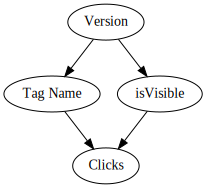

In [8]:
from graphviz import Digraph
dag = Digraph()
dag.node('T', 'Tag Name')
dag.node('S', 'isVisible')
dag.node('V', 'Version')
dag.node('C', 'Clicks')

dag.edges(['VT', 'VS', 'SC', 'TC'])
dag


Now, we use some R magic, to fit the data into a bayesian network and get the conditional probabailities.

``` {r}
# R code to be run separately.
library(bnlearn)
library(Rgraphviz)
library(dplyr)
net <- model2network("[version][isVisible|version][tagname|version][clicks|isVisible:tagname]")
graphviz.plot(net)

data = read.csv("https://gist.githubusercontent.com/mancunian1792/06ec31e69b8c10d5de28b7c4949a6538/raw/2bee970d5559ff07706aa537d96474b9e0dbb7e7/ab_testing_data.csv")

fit <- bn.fit(net, data, method="bayes")

fit
```

We take the conditional probabilities obtained and use them alongside pyro to answer few causal queries.

### **Conditional Probabalities**

In [9]:
# Getting the cpt tables from bnlearn fit values
V_alias = ['v1','v2','v3', 'v4', 'v5']
T_alias = ['a','area', 'button', 'center', 'div', 'font', 'form', 'img', 'input', 'li', 'object', 'p', 'span', 'strong', 'ul']
S_alias = ['False','True']
C_alias = ['HIGH','LOW', 'MEDHIGH', 'MEDIUM', 'MEDLOW']

In [10]:
!pip install torch==1.7.0
!pip install pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
import torch
import numpy as np

     |████████████████████████████████| 634 kB 904 kB/s 
     |████████████████████████████████| 735.5 MB 9.9 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.2.5 requires torch<1.8,>=1.7.0, but you have torch 1.8.0 which is incompatible.
allennlp 2.0.1 requires torch<1.8.0,>=1.6.0, but you have torch 1.8.0 which is incompatible.


In [11]:
import torch
V_prob = torch.tensor([0.23, 0.194, 0.207, 0.190, 0.177])
S_prob = torch.tensor([[0.16, 0.84], [0.19, 0.81], [0.22, 0.78], [0.08, 0.92], [0.11, 0.89]])

T_prob = torch.tensor([[0.404, 0.014, 0.014, 0.0001, 0.289, 0.0001, 0.01, 0.029, 0.014, 0.043, 0.0001, 0.043, 0.115, 0.0001, 0.01], 
                       [0.446, 0.017, 0.017, 0.0002, 0.240, 0.0002, 0.017, 0.034, 0.017, 0.0002, 0.0002, 0.103, 0.086, 0.0002, 0.0174], \
                       [0.4503, 0.016, 0.016, 0.032, 0.209, 0.0002, 0.016, 0.032, 0.016, 0.0002, 0.016, 0.080, 0.080, 0.016, 0.016], \
                       [0.489, 0.017, 0.017, 0.0002, 0.244, 0.0002, 0.0177, 0.052, 0.0177, 0.0177, 0.0002, 0.070, 0.035, 0.0002, 0.0177], \
                       [0.507, 0.019, 0.019, 0.019, 0.169, 0.019, 0.019, 0.037, 0.019, 0.0002, 0.0002, 0.0754, 0.0754, 0.0002, 0.019]])

C_prob = torch.tensor([[[0.0009, 0.996, 0.009, 0.009, 0.009], [0.03, 0.57, 0.007, 0.05, 0.33]],
                       [[0.20, 0.001, 0.001, 0.20, 0.59], [0.20, 0.20, 0.20, 0.20, 0.20]], \
                       [[0.20, 0.20, 0.20, 0.20, 0.20], [0.001, 0.001, 0.001, 0.20, 0.797]], \
                       [[0.002, 0.9912, 0.002, 0.002, 0.002], [0.2, 0.2, 0.2, 0.2, 0.2]], \
                       [[0.0003, 0.998, 0.0003, 0.0003, 0.0003], [0.0001, 0.9602, 0.0001, 0.0001, 0.03932]], \
                       [[0.0064, 0.9741, 0.0064, 0.0064, 0.0064], [0.2, 0.2, 0.2, 0.2, 0.2]], \
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.001, 0.796, 0.001, 0.001, 0.20]], \
                       [[0.002, 0.992, 0.002, 0.002, 0.002], [0.0009, 0.9962, 0.0009, 0.0009, 0.0009]], \
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.0013, 0.796, 0.00132, 0.00132]],\
                       [[0.2, 0.2, 0.2, 0.2, 0.2], [0.001, 0.993, 0.002, 0.002, 0.002]],\
                       [[0.0064, 0.974, 0.006, 0.006, 0.006],[0.2, 0.2, 0.2, 0.2, 0.2]],\
                       [[0.0011, 0.996, 0.001, 0.001, 0.001],[0.0004, 0.936, 0.0004, 0.0004, 0.0628]],\
                       [[0.2,0.2,0.2, 0.2, 0.2],[0.0003, 0.9157, 0.0003, 0.0003, 0.0835]],\
                       [[0.0065, 0.974, 0.0065, 0.0065, 0.0065],[0.2, 0.2, 0.2, 0.2, 0.2]],\
                       [[0.2, 0.2, 0.2, 0.2, 0.2],[0.0013, 0.9947, 0.0013, 0.0013, 0.0013]]])

In [12]:
def model():
    V = pyro.sample("V", dist.Categorical(probs=V_prob))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[V]))
    S = pyro.sample("S", dist.Categorical(probs=S_prob[V]))
    C = pyro.sample("C", dist.Categorical(probs=C_prob[T][S]))
    return{'V': V,'S': S,'T': T,'C': C}

**Association Query 1**: Infer the probability of versions, given an evidence. This is an interesting query as we go against the direction of the DAG.

**Evidence**: Click through is *MEDHIGH* and visibility of tag is *TRUE*


Text(0.5, 1.0, 'P(V | C = MEDHIGH, S= Visible) - Importance Sampling')

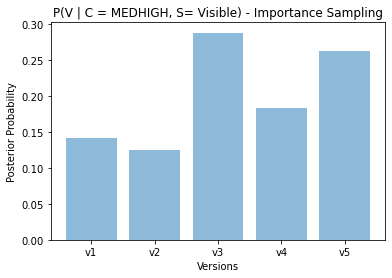

In [13]:
conditioned_model_1 = pyro.condition(model, data={'C':torch.tensor(2), 'S': torch.tensor(1)})

V_posterior = Importance(conditioned_model_1, num_samples=5000).run()
V_marginal = EmpiricalMarginal(V_posterior,"V")
V_samples = [V_marginal().item() for _ in range(5000)]
V_unique, V_counts = np.unique(V_samples, return_counts=True)

plt.bar(V_unique, V_counts/5000, align='center', alpha=0.5)
plt.xticks(V_unique, V_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Versions')
plt.title('P(V | C = MEDHIGH, S= Visible) - Importance Sampling')

Text(0.5, 1.0, 'P(V | do(C = MEDHIGH, S= Visible) - Importance Sampling')

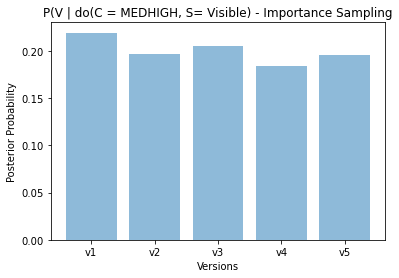

In [14]:
intervention_condition = pyro.do(model, data={'C':torch.tensor(2), 'S': torch.tensor(1)})

V_posterior = Importance(intervention_condition, num_samples=5000).run()
V_marginal = EmpiricalMarginal(V_posterior,"V")
V_samples = [V_marginal().item() for _ in range(5000)]
V_unique, V_counts = np.unique(V_samples, return_counts=True)

plt.bar(V_unique, V_counts/5000, align='center', alpha=0.5)
plt.xticks(V_unique, V_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Versions')
plt.title('P(V | do(C = MEDHIGH, S= Visible) - Importance Sampling')

**Association Query 2**: Infer the probability of tag names given evidence about click rate.

**Evidence**: Click through is *HIGH*

Text(0.5, 1.0, 'P(T | C = HIGH) - Importance Sampling')

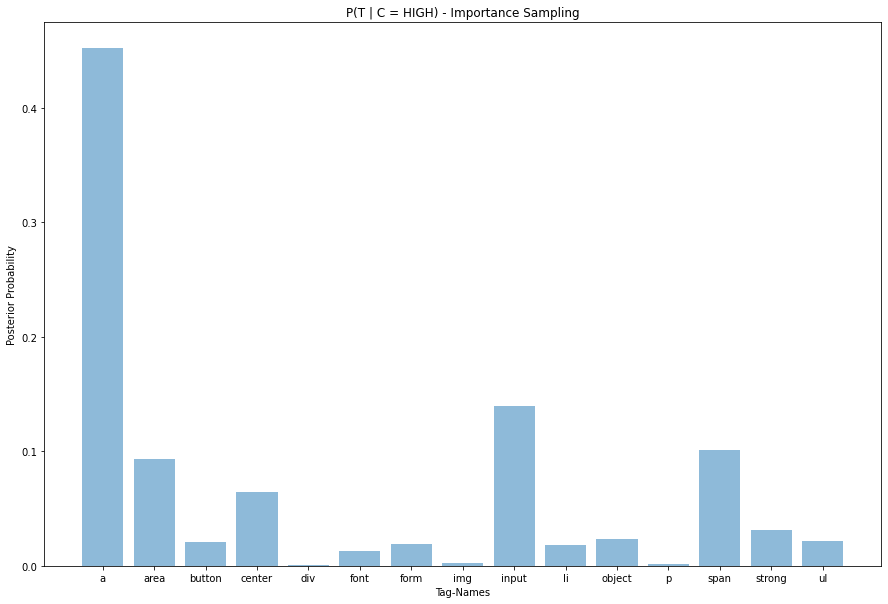

In [15]:
conditioned_model_2 = pyro.condition(model, data={'C':torch.tensor(0)})

T_posterior = Importance(conditioned_model_2, num_samples=5000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(5000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)
plt.figure(figsize=(15,10))
plt.bar(T_unique, T_counts/5000, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Tag-Names')
plt.title('P(T | C = HIGH) - Importance Sampling')

An interesting observation is that, from data, we see that the probability of the area tag in occuring is very low in 0.001 range. But given the evidence that the click rate is *HIGH* we see that the probability of the area tag goes up 10 fold.

**Intervention Query** - During intervention, the effect of the parent is negated. We try to negate the effect of visibility. What would happen if i make all the tags visible ? Hence, the effect of version disappears. What would be the 

**Evidence** - Visibility is True.

Text(0.5, 1.0, 'P(C | do(Visible=True)) - Importance Sampling')

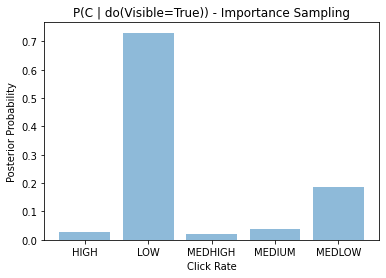

In [16]:
intervention_model_visible = pyro.do(model, data= {"S": torch.tensor(1)})

C_posterior = Importance(intervention_model_visible, num_samples=5000).run()
C_marginal = EmpiricalMarginal(C_posterior,"C")
C_samples = [C_marginal().item() for _ in range(5000)]
C_unique, C_counts = np.unique(C_samples, return_counts=True)
plt.bar(C_unique, C_counts/5000, align='center', alpha=0.5)
plt.xticks(C_unique, C_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Click Rate')
plt.title('P(C | do(Visible=True)) - Importance Sampling')

Text(0.5, 1.0, 'P(C | do(Visible=False) - Importance Sampling')

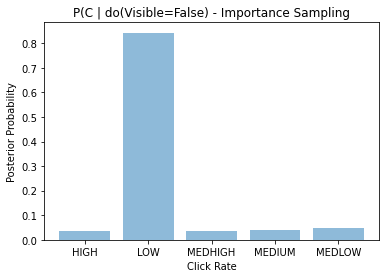

In [17]:
intervention_model_visible_no = pyro.condition(model, data= {"S": torch.tensor(0)})

C_posterior = Importance(intervention_model_visible_no, num_samples=5000).run()
C_marginal = EmpiricalMarginal(C_posterior,"C")
C_samples = [C_marginal().item() for _ in range(5000)]
C_unique, C_counts = np.unique(C_samples, return_counts=True)
plt.bar(C_unique, C_counts/5000, align='center', alpha=0.5)
plt.xticks(C_unique, C_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('Click Rate')
plt.title('P(C | do(Visible=False) - Importance Sampling')

### Causal Effect Query

**Does Setting visibility to TRUE for all elements make any effect ?**



In [18]:
def causal_effect(val):
  c_samples_visible = [
    1 if intervention_model_visible()['C'] == val else 0
    for _ in range(5000)
  ]
  c_samples_not_visible = [
      1 if intervention_model_visible_no()['C'] == val else 0
      for _ in range(5000)
  ]

  causal_effect = np.mean(c_samples_visible) - np.mean(c_samples_not_visible)
  return causal_effect

In [19]:
for lvl in C_alias:
  diff = causal_effect(C_alias.index(lvl))
  print(f"E(Click = {lvl} | do(Visible = True) - E(Click = {lvl} | do(Visible = False))) is {diff}")

E(Click = HIGH | do(Visible = True) - E(Click = HIGH | do(Visible = False))) is -0.006599999999999998
E(Click = LOW | do(Visible = True) - E(Click = LOW | do(Visible = False))) is -0.11819999999999997
E(Click = MEDHIGH | do(Visible = True) - E(Click = MEDHIGH | do(Visible = False))) is -0.0142
E(Click = MEDIUM | do(Visible = True) - E(Click = MEDIUM | do(Visible = False))) is -0.006999999999999999
E(Click = MEDLOW | do(Visible = True) - E(Click = MEDLOW | do(Visible = False))) is 0.15180000000000002


We see that by making all the tags visible, the probability of MED-LOW is increased and we see a massive decrease in LOW probability. Hence, we can say that there is a ~15% chance for the  click rates to increase from the 0-10 range to 10-100 range by making all the tags visible.

### P.S - If you're interested in combining causal inference with deep learning architecture and want to read about it, please checkout this [Tutorial](https://linkinnation1792.gitbook.io/causal-scene-generation/) and [this 10 minute summary](https://medium.com/swlh/causal-generative-modelling-a-brief-tutorial-with-game-character-images-728d3450b600)